In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
from src.llamma import LLAMMA
from src.controller import Controller
from src.oracle import Oracle
from src.mpolicy import MonetaryPolicy
from src.liquidator import Liquidator
import pandas as pd
import numpy as np
from datetime import datetime
from src.utils import _plot_borrowers, gen_gbm
import matplotlib.pyplot as plt
from src.utils import external_swap
import copy
import imageio

In [3]:
WINDOW = 600 # 10 minutes
BASE_PRICE = 1800
A = 100
# FEE = 0.006
FEE = 0
ADMIN_FEE = 1
LOAN_DISCOUNT = 0.09
LIQUIDATION_DISCOUNT = 0.06

N_BORROWERS = 100
VALUE = 60_000_000 # USD value of collateral
COINS = 60_000_000 / BASE_PRICE # Number of collateral coins
DEBT = 44_000_000 # crvUSD debt

TOLERANCE = 0 # Min profit for liquidator to act

START = int(datetime.now().timestamp())

oracle = Oracle(WINDOW)
oracle.update(START, BASE_PRICE) # set initial price
llamma = LLAMMA(A, BASE_PRICE, oracle, FEE, admin_fee=ADMIN_FEE)
mpolicy = MonetaryPolicy()
controller = Controller(llamma, mpolicy, LOAN_DISCOUNT, LIQUIDATION_DISCOUNT) 
liquidator = Liquidator(TOLERANCE, verbose=True)

Total collateral: 60 Mns USD
Total debt: 40 Mns USD


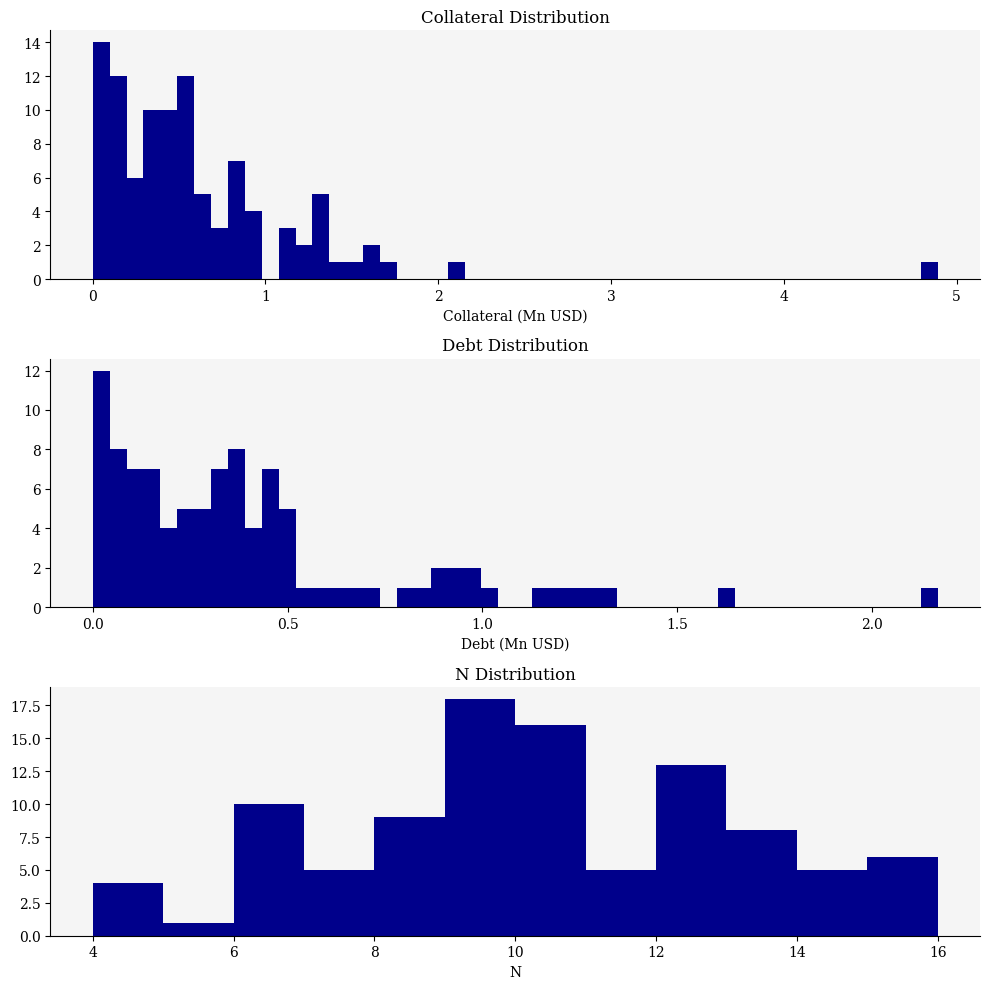

In [4]:
borrowers = controller.gen_borrowers(N_BORROWERS, COINS, v=True)
_plot_borrowers(borrowers, BASE_PRICE)

In [5]:
# Check that this generate func will generally give us ~
debts = []
for _ in range(1000):
    bs = controller.gen_borrowers(N_BORROWERS, COINS)
    debts.append(bs[:,1].sum())
print(f"Mean debt: {round(np.mean(debts) / 1e6)} Mns USD")
print(f"Desired debt: {DEBT / 1e6} Mns USD")

Mean debt: 39 Mns USD
Desired debt: 44.0 Mns USD


In [6]:
for i, b in enumerate(borrowers):
    # Deposit!
    controller.create_loan(i, *b)

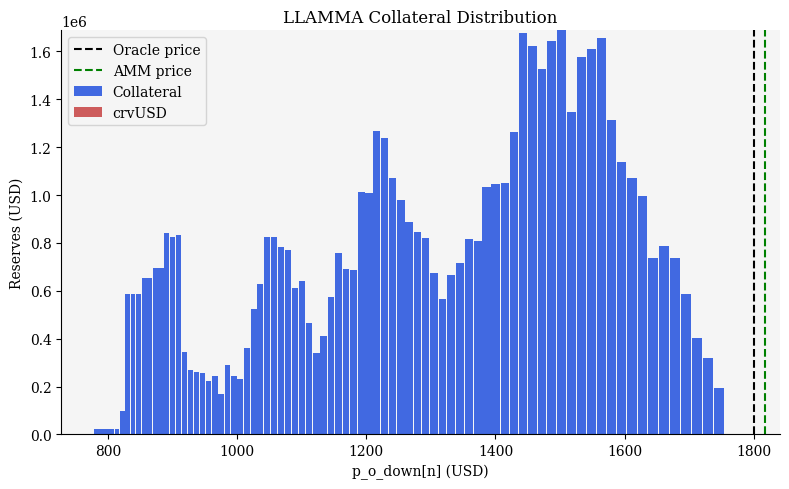

In [7]:
llamma.plot_reserves()

In [8]:
# NOTE run this to see that oracle updates affect llamma
# oracle.update(START + 60*60, BASE_PRICE * 0.9)
# llamma.plot_reserves()

Performed arbitrage, profit: 380668 USD


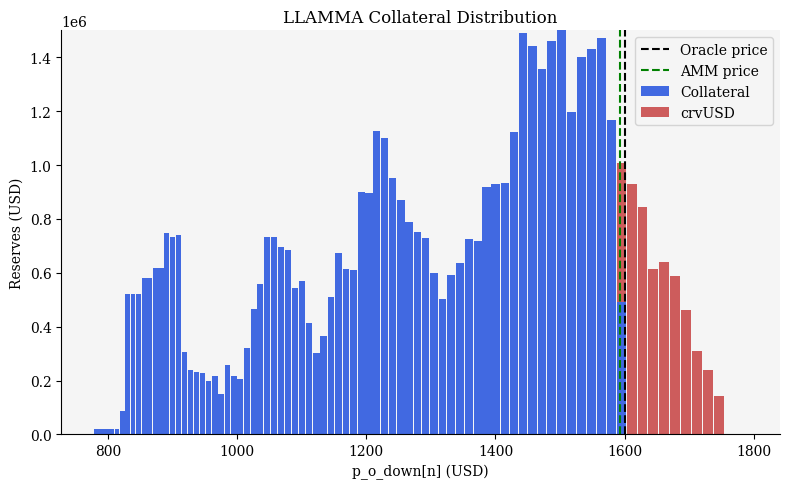

In [9]:
# NOTE if all fees are 0 and we there's very deep ext liquidity then arbitrageurs will equilibrate prices
# TODO incorporate this into a test!

p_mkt = 1600 # <- target price for arbitrage

ext_stable_liquidity = 2e10 # NOTE very high, ~ no slippage
ext_collat_liquidity = ext_stable_liquidity / p_mkt # <- external liquidity is at market price
ext_swap_fee = 0.005

llamma_cp = copy.deepcopy(llamma)
oracle_cp = copy.deepcopy(llamma.oracle)
llamma_cp.oracle = oracle_cp
oracle_cp.update(oracle_cp.last_timestamp + 60*1000, p_mkt) # <- update oracle to be close to market price

liquidator.arbitrage(llamma_cp, p_mkt, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)
llamma_cp.plot_reserves()


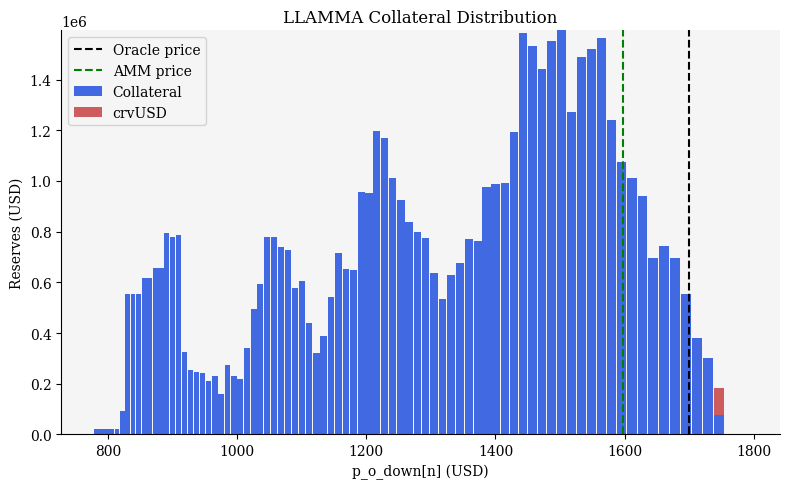

In [13]:
llamma_cp.plot_reserves()

In [15]:
sum(llamma_cp.bands_x.values())

106674.76384572312

In [25]:
# NOTE the problem is that when a band gets to 0 reserves the reported price is mid price and is not the target price
# Perhaps the problem is that you just can't get to a certain price! So if optimal p is not reachable

ps = [BASE_PRICE, 1750, 1700, 1775, 1600, 1650, 1500]

ext_stable_liquidity = 2e10 # NOTE very high, ~ no slippage
ext_collat_liquidity = ext_stable_liquidity / ps[0] # <- external liquidity is at market price
ext_swap_fee = 0.005

llamma_cp = copy.deepcopy(llamma)
oracle_cp = copy.deepcopy(llamma.oracle)
llamma_cp.oracle = oracle_cp

frame = 0
for p in ps:
    fn = f"./figs/test_{frame}.png"
    ext_collat_liquidity = ext_stable_liquidity / p # <- external liquidity is at market price
    oracle_cp.update(oracle_cp.last_timestamp + 60*1000, p) # <- update oracle to be close to market price
    liquidator.arbitrage(llamma_cp, p, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)
    llamma_cp.plot_reserves(fn)
    frame += 1

Performed arbitrage, profit: 570 USD
Performed arbitrage, profit: 23403 USD
Performed arbitrage, profit: 50089 USD
Performed arbitrage, profit: 364949 USD
Performed arbitrage, profit: 59336 USD
Performed arbitrage, profit: 755169 USD


In [ ]:
frames = [imageio.v2.imread(f"./figs/test_{i}.png") for i in range(len(ps))]
imageio.mimsave('./figs/test.gif', frames, fps=2)

(1440, 4)


<Axes: xlabel='timestamp'>

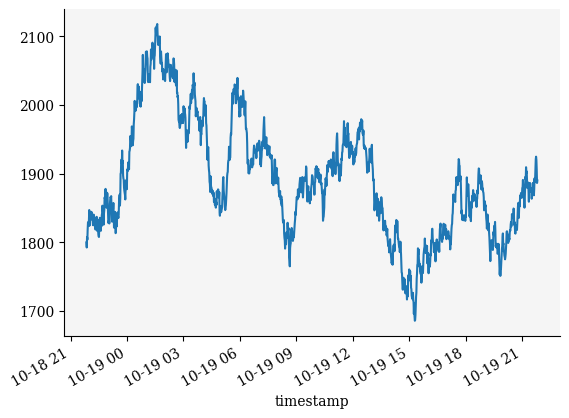

In [11]:
# Now let's create some dummy prices and assume that liquidators
# will liquidate when profitable.

WINDOW = 3600 # 1 hrs # NOTE this is way longer than the actual contract
PERIOD = 86400 # 1 day

times = [START] + [int(START + dt*60) for dt in range(1, PERIOD//60)]

df = pd.DataFrame(columns=['timestamp', 'spot', 'oracle', 'liquidator_pnl'])
df['timestamp'] = times
df.index = pd.to_datetime(df['timestamp'], unit='s')
df['spot'] = np.concatenate([[BASE_PRICE], gen_gbm(S0=BASE_PRICE,mu=-0.1, sigma=0.2, dt=1/1440,T=1)[1:]])
print(df.shape)
df['spot'].plot()

<Axes: xlabel='timestamp'>

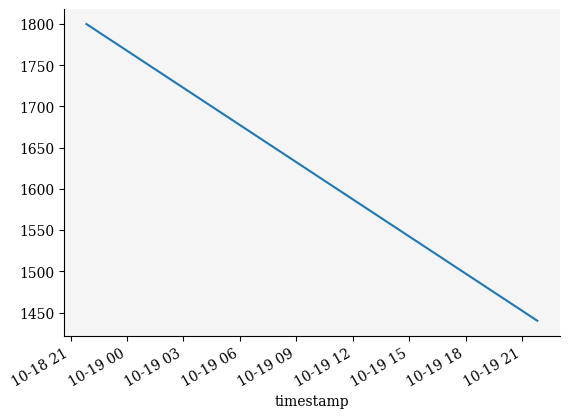

In [12]:
df['spot'] = np.linspace(BASE_PRICE, BASE_PRICE * 0.8, len(df))
df['spot'].plot()

In [26]:
# Init external market liquidity for slippage calc
ext_stable_liquidity = 2e16 # NOTE why 2M?
ext_collat_liquidity = ext_stable_liquidity / BASE_PRICE
ext_swap_fee = 0.005

# Run simulation
for i, row in df.iterrows():
    print(i)
    
    # Update oracle
    ema_price = oracle.update(row['timestamp'], row['spot'])
    df.loc[i, 'oracle'] = ema_price

    # Update external liquidity
    ext_collat_liquidity = ext_stable_liquidity / row['spot']

    # Check for liquidations
    # liquidator.perform_liquidations(controller, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)
    
    # Check for arbitrage
    liquidator.arbitrage(llamma, row['spot'], ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)
    df.loc[i, 'liquidator_pnl'] = liquidator.pnl


NameError: name 'df' is not defined

In [18]:
df.iloc[100:150]

,timestamp,spot,oracle,liquidation_pnl
timestamp,,,,
2023-10-18 23:30:13,1697671813,1774.982627,1777.361254,294283.55062
2023-10-18 23:31:13,1697671873,1774.732453,1777.11109,294283.55062
2023-10-18 23:32:13,1697671933,1774.482279,1776.860926,294283.55062
2023-10-18 23:33:13,1697671993,1774.232106,1776.610761,294284.42948
2023-10-18 23:34:13,1697672053,1773.981932,NaN,NaN
2023-10-18 23:35:13,1697672113,1773.731758,NaN,NaN
2023-10-18 23:36:13,1697672173,1773.481584,NaN,NaN
2023-10-18 23:37:13,1697672233,1773.231411,NaN,NaN
2023-10-18 23:38:13,1697672293,1772.981237,NaN,NaN


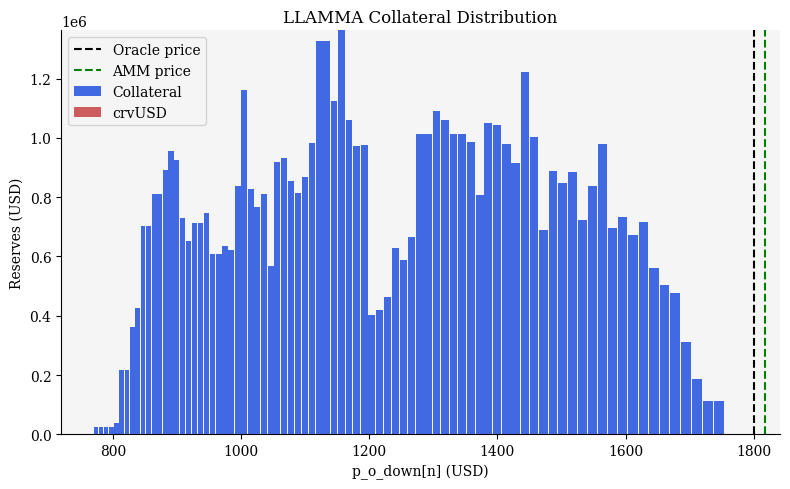

In [12]:
llamma.plot_reserves()

In [13]:
START

1697665473

In [14]:
df['timestamp'].iloc[0]

1697665473

<Axes: xlabel='timestamp'>

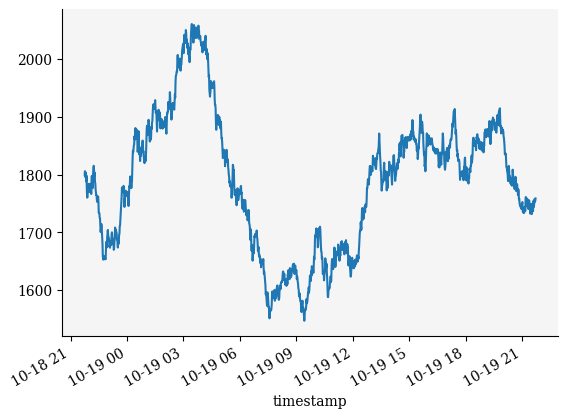

In [15]:
df['spot'].plot()
df['oracle'].plot()